#### Libraries importeren

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

#### Set seed

In [46]:
np.random.seed(42)
torch.manual_seed(42)

#### Dataset inladen en inzien
Voordat ik de data volledig ga transformeren, wil ik eerst het gemiddelde en de standaardafwijking weten voor de normalisatie. Daarnaast wil ik ook weten wat de grote van de afbeelding is qua pixels en het kanaal (grijstinten of rgb).

In [47]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

alle_afbeeldingen = torch.cat([image.unsqueeze(0) 
                               for image, _ in train_data], dim=0)

print(f"Gemiddelde: {alle_afbeeldingen.mean().item():.4f}, Standaardafwijking: {alle_afbeeldingen.std().item():.4f}")

Gemiddelde: 0.1307, Standaardafwijking: 0.3081


In [48]:
image, label = train_data[7]
print(f"Afbeelding formaat: {image.shape}")

Afbeelding formaat: torch.Size([1, 28, 28])


#### Data transformeren

In [6]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)), #Juiste afmetingen invoeren 
    transforms.RandomRotation(10),  #Willekeurige rotaties tot 10 graden
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)), #Willekeurige onregelmatigheden 
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) #Normalisatie op basis van het gem en standaardafwijking
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

#### Train data inspecteren

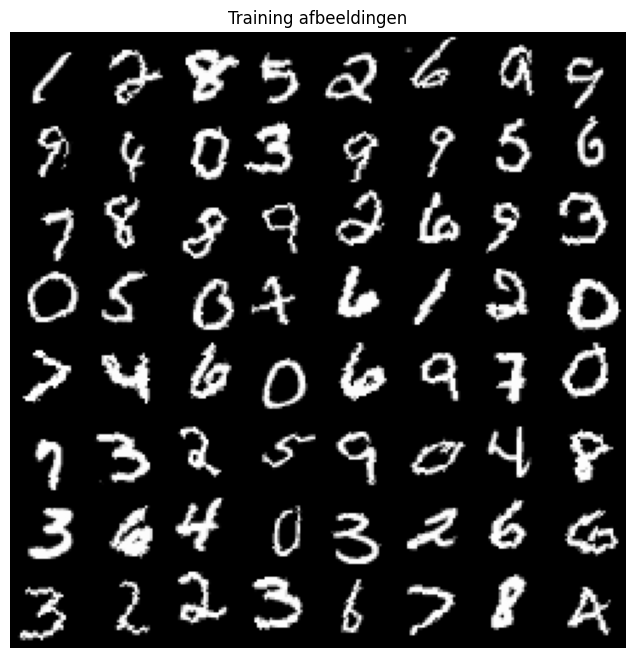

In [51]:
eerste_batch = next(iter(train_loader))
images, labels = eerste_batch

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title("Training afbeeldingen")

grid_afbeeldingen = np.transpose(vutils.make_grid(images[:64], padding=2, normalize=True).cpu(), (1, 2, 0))

plt.imshow(grid_afbeeldingen)
plt.show()

#### Architectuur van CNN bouwen

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    
    nn.Linear(64 * 3 * 3, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(128, 10)
)

#### Check voor GPU
I.v.m. dat het model zwaar kan zijn, check ik eerst ff of het huidige apparaat een GPU heeft. Dit kan het trainen een stuk versneller namelijk.

In [8]:
component = torch.device("cuda" if torch.cuda.is_available()
                         else "cpu")
model = model.to(component)
print(f"Model runt op {component}")

Model runt op cpu


#### Model trainen

In [9]:
optimalisator = optim.Adam(model.parameters(), lr=0.0001)
criterium = nn.CrossEntropyLoss()

In [ ]:
epochs = 10
for epoch in range(epochs):
    model.train()
    totale_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(component), labels.to(component) #Runt het model op geschikte component
        
        optimalisator.zero_grad()
        output = model(images)
        loss = criterium(output, labels)
        loss.backward()
        optimalisator.step()
        totale_loss += loss.item()
    
    print(f"Epoch {epoch + 1}, Loss: {totale_loss / len(train_loader)}")

torch.save(model.state_dict(), "Getrainde_modellen/CNN_Model_gewichten.pth")

Epoch 1, Loss: 1.15803704571241
Epoch 2, Loss: 0.4488177417850952
Epoch 3, Loss: 0.33683852812469894
Epoch 4, Loss: 0.28626266584944116
Epoch 5, Loss: 0.25135728523437023
Epoch 6, Loss: 0.22933634284383325
Epoch 7, Loss: 0.20827060000601608
Epoch 8, Loss: 0.19868981431939328
Epoch 9, Loss: 0.1843319878256175
Epoch 10, Loss: 0.17387218307306582


#### Laad getrainde model indien nodig (voor apparaten zonder cuda bijvoorbeeld)

In [10]:
model.load_state_dict(torch.load("Getrainde_modellen/CNN_Model_gewichten.pth", 
                                 map_location=torch.device(component)))


<All keys matched successfully>

#### Evaluatie van model

In [11]:
model.eval()
with torch.no_grad():
    correct_voorspeld = 0
    totaal_voorspeld = 0
    for images, labels in test_loader:
        images, labels = images.to(component), labels.to(component)
        test_output = model(images)
        _, predicted = torch.max(test_output, 1)
        correct_voorspeld += (predicted == labels).sum().item()
        totaal_voorspeld += labels.size(0)

accuratie = correct_voorspeld / totaal_voorspeld * 100

print("Werkelijke labels:", labels[:16].tolist())  
print("Voorspelde labels:", predicted[:16].tolist()) 
print(f"Accuratie na training: {accuratie:.2f}%")

Werkelijke labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
Voorspelde labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
Accuratie na training: 96.58%


#### Nieuwe data transformeren en inzien

(-0.5, 27.5, 27.5, -0.5)

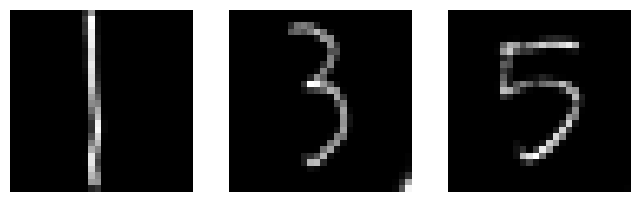

In [ ]:
Nummer1 =  Image.open("Afbeeldingen/Nummer1.jpg").convert("L")
Nummer3 =  Image.open("Afbeeldingen/Nummer3.jpg").convert("L")
Nummer5 =  Image.open("Afbeeldingen/Nummer5.jpg").convert("L")

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomInvert(p=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081))
])

def afbeelding_transformeren(afbeelding):
    #Afbeelding binariseren
    afbeelding = np.array(afbeelding)
    afbeelding = (afbeelding > 90) * 255
    afbeelding = Image.fromarray(afbeelding.astype(np.uint8))
    
    #Afbeelding verder transformeren
    afbeelding = transform(afbeelding)
    afbeelding = afbeelding.squeeze(0).numpy()
    return afbeelding

Nummer1 = afbeelding_transformeren(Nummer1)
Nummer3 = afbeelding_transformeren(Nummer3)
Nummer5 = afbeelding_transformeren(Nummer5)

fig, axes = plt.subplots(1, 3, figsize=(8,4))
axes[0].imshow(Nummer1, cmap='gray')
axes[0].axis('off')

axes[1].imshow(Nummer3, cmap='gray')
axes[1].axis('off')

axes[2].imshow(Nummer5, cmap='gray')
axes[2].axis('off')

In [106]:
def afbeelding_verwerken(afbeelding):
    afbeelding = torch.tensor(afbeelding, dtype=torch.float32)
    afbeelding = afbeelding.unsqueeze(0)
    afbeelding = afbeelding.to(component)
    return afbeelding
    
Nummer1 = afbeelding_verwerken(Nummer1)
Nummer3 = afbeelding_verwerken(Nummer3)
Nummer5 = afbeelding_verwerken(Nummer5)

#### Nieuwe data introduceren in CNN

In [107]:
model.eval()
with torch.no_grad():
    test_output = model(Nummer5)
    zekerheidsgraad = torch.softmax(test_output, dim=1)
    voorspelling = torch.argmax(zekerheidsgraad, 1).item()
    zekerheid = zekerheidsgraad[0][voorspelling].item()
    
    print(f"Het model denkt dat dit cijfer een {voorspelling} is met een zekerheidsgraad van {zekerheid:.4f}!")
    print(test_output)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x9 and 576x128)